In [ ]:
# Image Training only.ipynb

#  This code is for training the model

# for basic file navigation and driving mount
import os
from google.colab import drive

# some basic libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# importing for basic image operations
import cv2 as cv
from PIL import Image
from PIL import ImageOps
import seaborn as sns
from datetime import datetime

# importing pretrained models
from tensorflow.keras.applications import efficientnet

# for splitting data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# prerequisites for training models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# for selecting better metrics
from sklearn.metrics import roc_auc_score

# initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

drive.mount('/content/gdrive')

s = "target"

Mounted at /content/gdrive


In [ ]:
## Image Training

TRAIN_IMG_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/imagens_bd/results_train/"

# converts all images for transformations
X = []
y = []

#classes = ["residential", "mixed", "commercial", "others", "industrial"]
classes = ["residential", "commercial", "others", "industrial"]
INPUT_IMG_WIDTH = 250
INPUT_IMG_HEIGHT = 350
VERTICAL = True

In [ ]:
# Para Pillow 9.1.0 ou superior
try:
    from PIL import Resampling
    RESAMPLING_METHOD = Resampling.LANCZOS
except ImportError:
    RESAMPLING_METHOD = Image.LANCZOS

# memory management in python by some medium article asian woman

for class_no, img_class in enumerate(classes):

    for aug_index, img_file in enumerate(os.listdir(TRAIN_IMG_DIR_PATH + img_class + '/')):

        img = Image.open(TRAIN_IMG_DIR_PATH + img_class + '/' + img_file)
        img = ImageOps.fit(img, (INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT), RESAMPLING_METHOD)

        # if you want to run on no augmentation
        np_img1 = np.array(img).astype(np.float16)
        X.append(np_img1)
        y.append(class_no)

        # if you want to run on augmentation (for every 1 image, 2 additional images)
        if aug_index % 6 == 0:
            img2 = ImageOps.mirror(img)
            np_img2 = np.array(img2).astype(np.float16)
            X.append(np_img2)
            y.append(class_no)

    print(f"{img_class} pre-processing completed!")

residential pre-processing completed!
commercial pre-processing completed!
others pre-processing completed!
industrial pre-processing completed!


In [ ]:
# dataset here
X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
del X, y

# convert to one-hot encoded vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# problem specific stuff
if VERTICAL:
    _temp_measure = INPUT_IMG_WIDTH
    INPUT_IMG_WIDTH = INPUT_IMG_HEIGHT
    INPUT_IMG_HEIGHT = _temp_measure

history_dict = []


In [ ]:
# Configuração do TensorBoard
from datetime import datetime

log_dir = "/content/gdrive/MyDrive/Colab Notebooks/TCC/logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Gera histograms
    write_graph=True,   # Grava o grafo do modelo
    write_images=True,  # Salva imagens (como visualizações de filtros)
    update_freq='epoch', # Frequência de atualização
    profile_batch=0,    # Não gera perfil de desempenho
)

In [ ]:
from datetime import datetime

with strategy.scope():

    # using tensorflow API for pretrained models and intializing them
    resnet_model = efficientnet.EfficientNetB7(input_shape=(INPUT_IMG_WIDTH, INPUT_IMG_HEIGHT, 3), include_top=False)

    # freezing base layers, as these are already pretrained with millions of parameters
    resnet_model.trainable = False

    # creating Sequential models
    model_resnet = Sequential([
        resnet_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.175),
        tf.keras.layers.Dense(16, activation='softmax'),
        tf.keras.layers.Dropout(0.125),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    # compiling models with metric Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    model_resnet.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy
    (from_logits=False), metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])

    history_resnet = model_resnet.fit(np.array(X_train), np.array(y_train), epochs=100, validation_data=
     (np.array(X_test), np.array(y_test)), batch_size=64, callbacks=[tensorboard_callback])
    print("----------------------------------------------------")

    # saving history
    history_dict.append(history_resnet)

model_resnet.save("/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/modelo_bd_4(20ep).keras")

# Análise dos resultados

val_acc = history_dict[0].history['val_accuracy']
train_acc = history_dict[0].history['accuracy']
val_loss = history_dict[0].history['val_loss']
train_loss = history_dict[0].history['loss']

# random probability of prediction
train_acc = [0.25] + train_acc
val_acc = [0.25] + val_acc

# starting assumption to have mean of loss of first two
mean_loss = (val_loss[0] + train_loss[0]) / 2
train_loss = [mean_loss] + train_loss
val_loss = [mean_loss] + val_loss

import pandas as pd
results_df = pd.DataFrame([train_acc, val_acc, train_loss, val_loss]).rename({0: 'ta', 1: 'va', 2: 'tl', 3: 'vl'}).T.reset_index().rename(columns={'index': 'num'})
results_df.head()

plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='ta',)
sns.lineplot(data=results_df, x='num', y='va',)
plt.title("Accuracy Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Metric)")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/accuracy_plot.png')
plt.close()

plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='tl',)
sns.lineplot(data=results_df, x='num', y='vl',)
plt.title("Loss Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy (Loss)")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo/loss_plot.png')
plt.close()


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 229s 117s/step - accuracy: 0.1634 - auc: 0.3551 - loss: 1.4178 - val_accuracy: 0.1333 - val_auc: 0.4926 - val_loss: 1.3864
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 186s 107s/step - accuracy: 0.2680 - auc: 0.5505 - loss: 1.3800 - val_accuracy: 0.3667 - val_auc: 0.7454 - val_loss: 1.3597
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 199s 106s/step - accuracy: 0.5407 - auc: 0.7922 - loss: 1.3422 - val_accuracy: 0.5667 - val_auc: 0.7865 - val_loss: 1.3378
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 202s 95s/step - accuracy: 0.5715 - auc: 0.8012 - loss: 1.3217 - val_accuracy: 0.5000 - val_auc: 0.7844 - val_loss: 1.3217
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 194s 95s/step - accuracy: 0.5331 - auc: 0.8103 - loss: 1.2987 - val_accuracy: 0.5000 - val_auc: 0.7624 - val_loss: 1.3105
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 212s 108s/step - accuracy: 0.5947 - auc: 0.8077 - loss: 1.2855 - val_accuracy: 0.5000 - val_auc: 0.7606 - val_lo

* TensorBoard

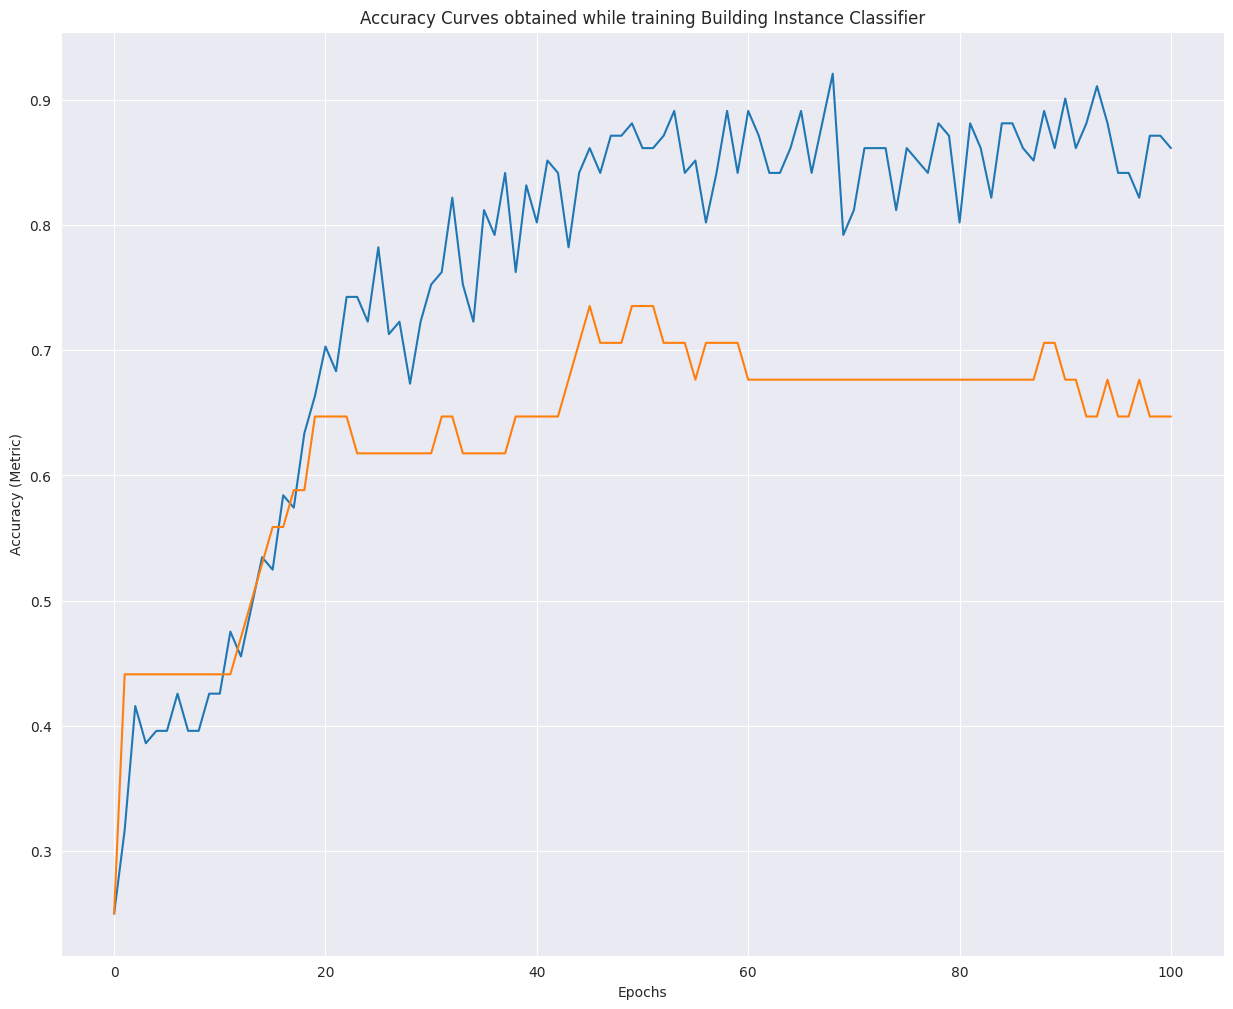

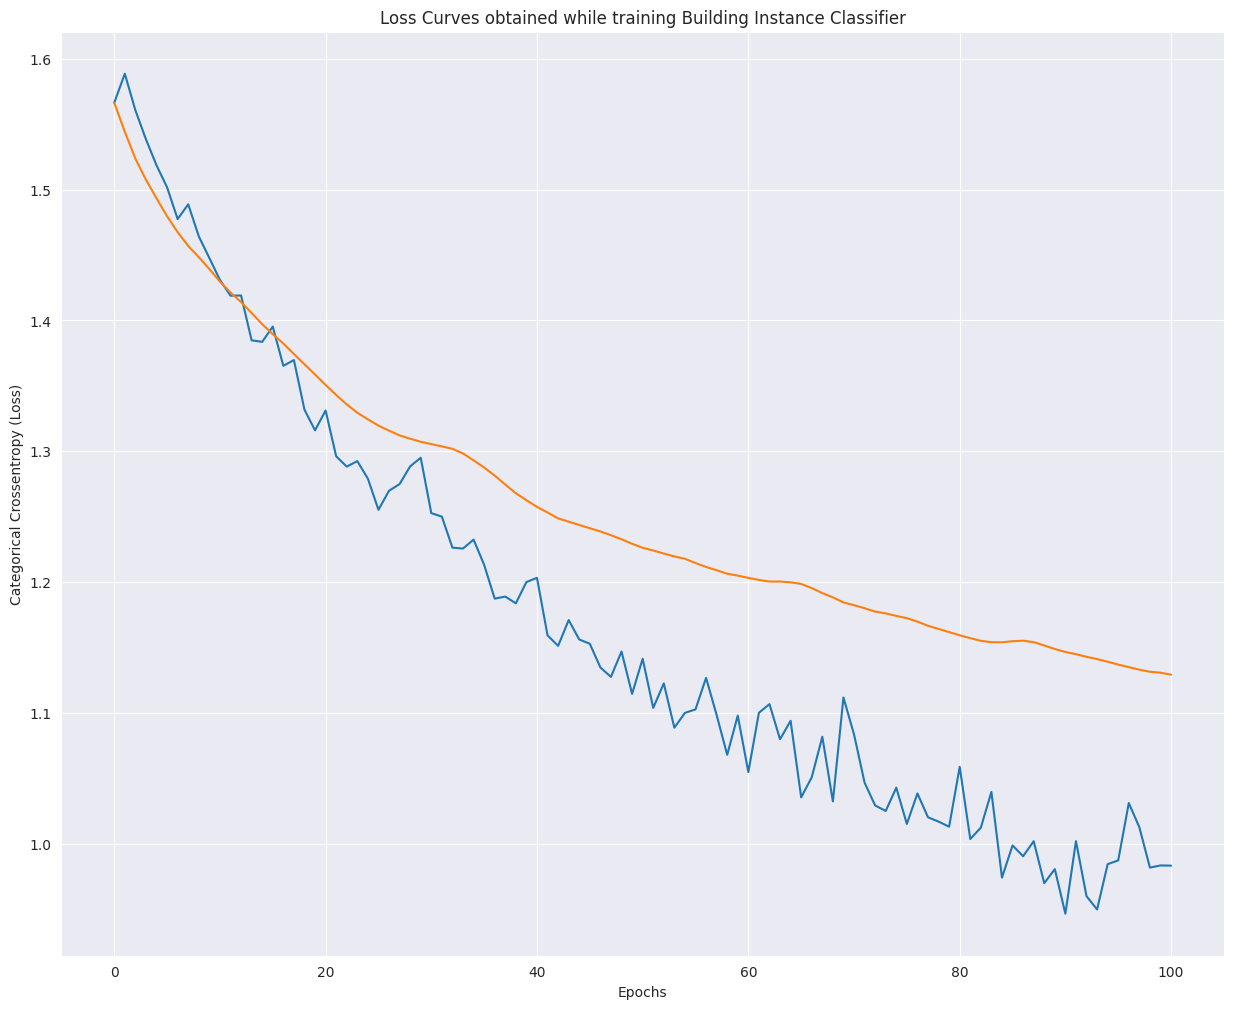

In [ ]:
# Análise dos resultados

val_acc = history_dict[0].history['val_accuracy']
train_acc = history_dict[0].history['accuracy']
val_loss = history_dict[0].history['val_loss']
train_loss = history_dict[0].history['loss']

# random probability of prediction
train_acc = [0.25] + train_acc
val_acc = [0.25] + val_acc

# starting assumption to have mean of loss of first two
mean_loss = (val_loss[0] + train_loss[0]) / 2
train_loss = [mean_loss] + train_loss
val_loss = [mean_loss] + val_loss

import pandas as pd
results_df = pd.DataFrame([train_acc, val_acc, train_loss, val_loss]).rename({0: 'ta', 1: 'va', 2: 'tl', 3: 'vl'}).T.reset_index().rename(columns={'index': 'num'})
results_df.head()

sns.set_style('darkgrid')
plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='ta',)
sns.lineplot(data=results_df, x='num', y='va',)
plt.title("Accuracy Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (Metric)")
plt.show()

sns.set_style('darkgrid')
plt.figure(figsize=(15, 12))
sns.lineplot(data=results_df, x='num', y='tl',)
sns.lineplot(data=results_df, x='num', y='vl',)
plt.title("Loss Curves obtained while training Building Instance Classifier")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy (Loss)")
plt.show()